In [1]:
import numpy as np
import astroscrappy
import os
import matplotlib.pyplot as plt
import batman

from astropy.io import fits
from astropy.stats import sigma_clip, mad_std
from astropy.time import Time
from astropy.table import QTable, vstack, hstack
from astropy.modeling import models, fitting

from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry

from datetime import datetime, UTC, timezone
from pathlib import Path
from glob import glob

# Imports

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def create_median_bias(bias_list = [
    'TOI_4463_Data/Bias_BIN1_20250511_074228.fits',
    'TOI_4463_Data/Bias_BIN1_20250511_074243.fits',
    'TOI_4463_Data/Bias_BIN1_20250511_074255.fits',
    'TOI_4463_Data/Bias_BIN1_20250511_074307.fits',
    'TOI_4463_Data/Bias_BIN1_20250511_074318.fits',
    'TOI_4463_Data/Bias_BIN1_20250511_074330.fits',
    'TOI_4463_Data/Bias_BIN1_20250511_074343.fits'
], median_bias_filename = 'median_bias_file.fits'):

    # Creating empty list for future trimmed biases.
    trimmed_biases = []

    # Calling each bias and trimming to 1024x1024, for less memory use.
    for fname in bias_list:
        with fits.open(fname, memmap=False) as hdul:
                data = hdul[0].data
                trimmed = data[1536:2560, 1536:2560]  # Center cut of 1024x1024
                trimmed_biases.append(trimmed)

    # Stacking trimmed biases in a 3D numpy array.
    bias_stack = np.stack(trimmed_biases, axis=0)

    # Sigma clipping is applied with the 3-sigma along axis=0.
    clipped = sigma_clip(bias_stack, sigma=3, axis=0, masked=True)

    # Computing bias medians while purposely ignoring masked values.
    median_bias = np.ma.median(clipped, axis=0).filled(np.nan)  # Masked pixels are filled with 'nan'

    # Defining FITs header with more information.
    header = fits.Header()

    # Included date, frame number, clipping, sigma clipping threshold, and trimmed region information.
    header['DATE'] = datetime.now(UTC).isoformat(), 'File created. UTC'
    header['NFRAMES'] = len(bias_list), 'Number of bias frames combined'
    header['CLIP'] = 'Sigma-clipping', 'Method of Combination'
    header['SIGMA'] = 3.0, 'Threshold of Sigma-clipping'
    header['TRIMMED'] = '[1536:2560,1536:2560]', 'Trimmed region of input frames'

    # Creating FITs file from the resulting median bias frame. 
    primary = fits.PrimaryHDU(data=median_bias, header=header)
    hdul = fits.HDUList([primary])
    hdul.writeto(median_bias_filename, overwrite=True)

    return median_bias

In [3]:
def create_median_dark(dark_list = [
    'TOI_4463_Data/Dark_BIN1_20250511_074356.fits',
    'TOI_4463_Data/Dark_BIN1_20250511_074459.fits',
    'TOI_4463_Data/Dark_BIN1_20250511_074603.fits',
    'TOI_4463_Data/Dark_BIN1_20250511_074707.fits',
    'TOI_4463_Data/Dark_BIN1_20250511_074812.fits'
], bias_filename = 'median_bias_file.fits', median_dark_filename = 'median_dark_file.fits'):

    # Empty list for future trimmed darks.
    trimmed_darks = []

    # Loading in the bias frame.
    with fits.open(bias_filename, memmap=False) as hdul_bias:
        bias_frame = hdul_bias[0].data
        bias_trimmed = bias_frame  # Bias frame is already trimmed, set 'bias_trimmed' to 'bias_frame'

    # Processing each of the dark files.
    for fname in dark_list:
         with fits.open(fname, memmap=False) as hdul:
            data = hdul[0].data
            header = hdul[0].header

    trimmed = data[1536:2560, 1536:2560]  # Trimming the dark frames.
    bias_corrected = trimmed - bias_trimmed  # Subtracting biases from dark frames.

    # Getting the exposure time 'EXPTIME' column. 
    try:
        exptime = header['EXPTIME']
    except KeyError:
        raise ValueError(f"Could not find exposure time in header of {fname}")

    # Finding dark current by having corrected bias / exposure time. 
    dark_current = bias_corrected / exptime

    trimmed_darks.append(dark_current) # Appending dark currents to trimmed darks. 

    # Stacking and performing sigma-clipping on dark frames. 
    dark_stack = np.stack(trimmed_darks, axis=0)
    clipped = sigma_clip(dark_stack, sigma=3, axis=0, masked=True)
    median_dark = np.ma.median(clipped, axis=0).filled(np.nan)

    # Creating FITs header with information.
    header = fits.Header()
    header['DATE'] = datetime.now(UTC).isoformat(), 'Date of dark frame creation (UTC)'
    header['NFRAMES'] = len(dark_list), 'Number of dark frames combined'
    header['CLIP'] = 'Sigma-clipping', 'Combination method'
    header['SIGMA'] = 3.0, 'Sigma clipping threshold'
    header['TRIMMED'] = '[1536:2560,1536:2560]', 'Trimmed region of input frames'
    header['UNITS'] = 'ADU/sec', 'Units are electrons or counts per second'

    # Save to a FITs file. 
    primary = fits.PrimaryHDU(data=median_dark, header=header)
    hdul = fits.HDUList([primary])
    hdul.writeto(median_dark_filename, overwrite=True)

    return median_dark

In [4]:
def create_median_flat(flat_list = [
    'TOI_4463_Data/domeflat_g_001-2-2.fits',
    'TOI_4463_Data/domeflat_g_001-2.fits',
    'TOI_4463_Data/domeflat_g_002-2.fits',
    'TOI_4463_Data/domeflat_g_002.fits',
    'TOI_4463_Data/domeflat_g_003-2.fits',
    'TOI_4463_Data/domeflat_g_003.fits',
    'TOI_4463_Data/domeflat_g_004-2.fits',
    'TOI_4463_Data/domeflat_g_004.fits',
    'TOI_4463_Data/domeflat_g_005-2.fits',
    'TOI_4463_Data/domeflat_g_005.fits',
    'TOI_4463_Data/domeflat_g_006-2.fits',
    'TOI_4463_Data/domeflat_g_006.fits',
    'TOI_4463_Data/domeflat_g_007-2.fits',
    'TOI_4463_Data/domeflat_g_007.fits'
],
    bias_filename = 'median_bias_file.fits',
    median_flat_filename = 'median_flat_file.fits',
    dark_filename=None,
):

    # Empty list for future trimmed flats.
    trimmed_flats = []

    # Re-calling bias frame.
    with fits.open(bias_filename, memmap=False) as hdul_bias:
        bias_frame = hdul_bias[0].data
        bias_trimmed = bias_frame # Trimmed bias.

    # Calling dark frame.
    if dark_filename is not None:
        with fits.open(dark_filename, memmap=False) as hdul_dark:
            dark_frame = hdul_dark[0].data
            dark_trimmed = dark_frame # Trimmed and normalized to ADU/sec

    # Processing each of the flat files.
    for fname in flat_list:
        with fits.open(fname, memmap=False) as hdul:
            data = hdul[0].data
            header = hdul[0].header

    trimmed = data[1536:2560, 1536:2560] # Trimming flat files.

    corrected = trimmed - bias_trimmed # Subtracting bias from frames.

    # Subtracting dark frame.
    if dark_filename is not None:
        try:
            exptime = header['EXPTIME']
        except KeyError:
            raise ValueError(f"Exposure time not found in header of {fname}")
        corrected -= dark_trimmed * exptime

    trimmed_flats.append(corrected)

    # Stacking the flats and sigma clipping them. 
    flat_stack = np.stack(trimmed_flats, axis=0)
    clipped = sigma_clip(flat_stack, sigma=3, axis=0, masked=True)
    median_flat = np.ma.median(clipped, axis=0).filled(np.nan)

    # Normalizing with the median value while ignoring nans.
    norm_median_flat = median_flat / np.nanmedian(median_flat)

    # Creating a more detailed FITS header with information on data, number of frames, etc. 
    header = fits.Header()
    header['DATE'] = datetime.now(UTC).isoformat(), 'Date of flat field creation (UTC)'
    header['NFRAMES'] = len(flat_list), 'Number of flat frames combined'
    header['CLIP'] = 'Sigma-clipping', 'Combination method'
    header['SIGMA'] = 3.0, 'Sigma clipping threshold'
    header['TRIMMED'] = '[1536:2560,1536:2560]', 'Trimmed region of input frames'
    header['NORMALIZ'] = 'By median', 'Flat normalized to median'
    if dark_filename:
        header['DARKSUB'] = True, 'Dark subtraction applied'
    else:
        header['DARKSUB'] = False, 'No dark subtraction applied'

    # Saving to a FITS file. 
    primary = fits.PrimaryHDU(data=norm_median_flat, header=header)
    hdul = fits.HDUList([primary])
    hdul.writeto(median_flat_filename, overwrite=True)

    return median_flat

In [5]:
def reduce_science_frame(
    science_filename = 'TOI_4463_Data/TOI4463_g_20250511_075808.fits',
    median_bias_filename = 'median_bias_file.fits',
    median_flat_filename = 'median_flat_file.fits',
    median_dark_filename = 'median_dark_file.fits',
    reduced_science_filename="reduced_science.fits",
    remove_cosmic_rays=True,
):

    # Reading in the science frame. 
    with fits.open(science_filename) as hdul:
        science_data = hdul[0].data.astype(float)
        science_header = hdul[0].header

    # Reading in bias frame. 
    with fits.open(median_bias_filename) as hdul:
        bias_data = hdul[0].data.astype(float)

    # Reading in median dark frame
    with fits.open(median_dark_filename) as hdul:
        dark_data = hdul[0].data.astype(float)

    # Reading in median normalized flat frame. 
    with fits.open(median_flat_filename) as hdul:
        flat_data = hdul[0].data.astype(float)

    # Getting exposure time from science file header. 
    exptime = science_header.get('EXPTIME')
    if exptime is None:
        raise ValueError(f"EXPTIME keyword not found in {science_filename} header.")

    # Need to trim science data to 1024x1024 to match the trimmed bias, dark, and flat files.
    if science_data.shape == (1024, 1024):
        science_trimmed = science_data
    else:
        science_trimmed = science_data[1536:2560, 1536:2560]

    # Subtracting the bias data from the now trimmed science file.
    data_sub_bias = science_trimmed - bias_data
    data_sub_dark = data_sub_bias - (dark_data * exptime)

    # Applying flat field correction.
    with np.errstate(divide='ignore', invalid='ignore'):
        reduced_data = np.true_divide(data_sub_dark, flat_data)
        reduced_data[~np.isfinite(reduced_data)] = 0  # The inf and nan are set to zero.

    # Removing cosmic rays when needed. 
    if remove_cosmic_rays:
        
        cr_mask, cleaned_data = astroscrappy.detect_cosmics(reduced_data)
        reduced_data = cleaned_data # Returning cleaned and masked frame.

    # More detailed header with metadata.
    science_header['HISTORY'] = 'Reduced with custom pipeline'
    science_header['HISTORY'] = f'Bias, dark, flat corrections applied'
    science_header['HISTORY'] = f'Cosmic rays removed: {remove_cosmic_rays}'
    science_header['REDUCED'] = Time.now().isot
    science_header['REDDATE'] = datetime.now(timezone.utc).isoformat(timespec='seconds')
    science_header['REDUSER'] = 'Jehu Gonzalez-Zarate'
    science_header['BIASFILE'] = median_bias_filename
    science_header['DARKFILE'] = median_dark_filename
    science_header['FLATFILE'] = median_flat_filename
    science_header['COMMENT'] = 'Reduced science frame for photometry'
    science_header['COMMENT'] = 'Trimmed to center 1024x1024 region'

    # Saving reduced science frame as FITS file.
    hdu = fits.PrimaryHDU(data=reduced_data, header=science_header)
    hdu.writeto(reduced_science_filename, overwrite=True)

    return reduced_data

In [6]:
def batch_reduce_all_science_frames(
    science_folder='TOI_4463_Data/',
    output_folder='reduced_science',
    median_bias='median_bias_file.fits',
    median_dark='median_dark_file.fits',
    median_flat='median_flat_file.fits'
):
    # Makes sure to create an output folder.
    os.makedirs(output_folder, exist_ok=True)

    # Sorts through all the science images from TOI_4463_Data folder
    science_files = sorted(glob(os.path.join(science_folder, 'TOI4463_g_*.fits')))

    print(f"Found {len(science_files)} science frames.")

    for sci_file in science_files:
        filename = os.path.basename(sci_file)
        reduced_name = os.path.join(output_folder, f"reduced_{filename}")

        print(f"Reducing {filename}...")

        try:
            reduce_science_frame(
                science_filename=sci_file,
                median_bias_filename=median_bias,
                median_dark_filename=median_dark,
                median_flat_filename=median_flat,
                reduced_science_filename=reduced_name,
                remove_cosmic_rays=True
            )
            print(f"Saved reduced frame to {reduced_name}")
        except Exception as e:
            print(f"Error reducing {filename}: {e}")

In [7]:
batch_reduce_all_science_frames(
    science_folder='TOI_4463_Data',
    output_folder='TOI_4463_Data/reduced_science',
    median_bias='TOI_4463_Data/median_bias_file-2.fits',
    median_dark='TOI_4463_Data/median_dark_file-2.fits',
    median_flat='TOI_4463_Data/median_flat_file-2.fits'
)

Found 56 science frames.
Reducing TOI4463_g_20250511_075808.fits...
Saved reduced frame to TOI_4463_Data/reduced_science/reduced_TOI4463_g_20250511_075808.fits
Reducing TOI4463_g_20250511_080212.fits...
Saved reduced frame to TOI_4463_Data/reduced_science/reduced_TOI4463_g_20250511_080212.fits
Reducing TOI4463_g_20250511_080434.fits...
Saved reduced frame to TOI_4463_Data/reduced_science/reduced_TOI4463_g_20250511_080434.fits
Reducing TOI4463_g_20250511_080659.fits...
Saved reduced frame to TOI_4463_Data/reduced_science/reduced_TOI4463_g_20250511_080659.fits
Reducing TOI4463_g_20250511_080920.fits...
Saved reduced frame to TOI_4463_Data/reduced_science/reduced_TOI4463_g_20250511_080920.fits
Reducing TOI4463_g_20250511_081213.fits...
Saved reduced frame to TOI_4463_Data/reduced_science/reduced_TOI4463_g_20250511_081213.fits
Reducing TOI4463_g_20250511_081718.fits...
Saved reduced frame to TOI_4463_Data/reduced_science/reduced_TOI4463_g_20250511_081718.fits
Reducing TOI4463_g_20250511_08

In [8]:
def do_aperture_photometry(
    image='reduced_science.fits',
    positions=[(509.651, 511.326), (363, 345), (832.334, 911.131), (516, 68), (514, 786), (307.08, 760.36)],
    radii=[8.32, 9.32, 10.32],
    sky_annulus_width=8.0,
):
    
    # Reading data from image
    with fits.open(image) as hdul:
        data = hdul[0].data

    # Empty list for results later on.
    all_results = []

    for radius in radii:
        sky_radius_in = radius + 1.5  # Sky annulus just outside aperture.

        aperture = CircularAperture(positions, r=radius)
        annulus = CircularAnnulus(positions, r_in=sky_radius_in, r_out=sky_radius_in + sky_annulus_width)

        # Background medians are calculated.
        annulus_masks = annulus.to_mask(method='center')
        bkg_median = []
        for mask in annulus_masks:
            annulus_data = mask.multiply(data)
            annulus_data_1d = annulus_data[mask.data > 0]
            median_val = np.median(annulus_data_1d)
            bkg_median.append(median_val)
        bkg_median = np.array(bkg_median)

        phot_table = aperture_photometry(data, aperture)
        phot_table.meta.clear() # Clearing meta data.
        aperture_area = aperture.area

        phot_table['bkg'] = bkg_median
        phot_table['bkg_sum'] = bkg_median * aperture_area
        phot_table['net_flux'] = phot_table['aperture_sum'] - phot_table['bkg_sum']
        phot_table['aperture_radius'] = radius

        all_results.append(phot_table)

    # Vertically combining tables, with additional column for radius. 
    from astropy.table import vstack
    final_table = vstack(all_results)

    return final_table

In [9]:
science_folder='TOI_4463_Data/reduced_science/'

# Sorting through science files.
science_files = sorted(glob(os.path.join(science_folder, 'reduced_TOI4463_g_*.fits')))
all_photometry = [] # Empty list for photometry.

# Looping over each file and applying photometry.
for file in science_files:
    print(f"Processing: {file}")
    
    phot_table = do_aperture_photometry(image=file)

    # Adding filenames.
    phot_table['filename'] = os.path.basename(file)

    # Extracting time from header for future plotting.
    with fits.open(file) as hdul:
        hdr = hdul[0].header
        time_obs = hdr.get('DATE-OBS', 'UNKNOWN') 
    phot_table['time'] = time_obs

    all_photometry.append(phot_table)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
Processing: TOI_4463_Data/reduced_science/reduced_TOI4463_g_20250511_075808.fits
Processing: TOI_4463_Data/reduced_science/reduced_TOI4463_g_20250511_080212.fits
Processing: TOI_4463_Data/reduced_science/reduced_TOI4463_g_20250511_080434.fits
Processing: TOI_4463_Data/reduced_science/reduced_TOI4463_g_20250511_080659.fits
Processing: TOI_4463_Data/reduced_science/reduced_TOI4463_g_20250511_080920.fits
Processing: TOI_4463_Data/reduced_science/reduced_TOI4463_g_20250511_081213.fits
Processing: TOI_4463_Data/reduced_science/reduced_TOI4463_g_20250511_081718.fits
Processing: TOI_4463_Data/reduced_science/reduced_TOI4463_g_20250511_082014.fits
Processing: TOI_4463_Data/reduced_science/reduced_TOI4463_g_20250511_082250.fits
Processing: TOI_4463_Data/reduced_science/reduced_TOI4463_g_20250511_082525.fits
Processing: TOI_4463_Data/reduced_science/reduce

In [10]:
# Combining results into a table.
master_table = vstack(all_photometry)

# Saving to a csv file. 
master_table.write('toi4463_photometry.csv', format='ascii.csv', overwrite=True)

print("Aperture photometry complete for all 57 files.")

Aperture photometry complete for all 57 files.


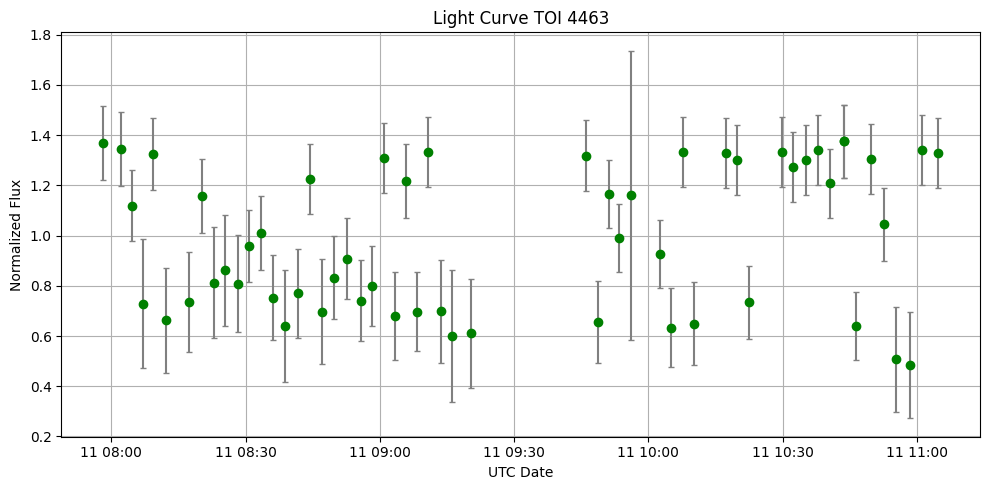

In [11]:
# Defining png file.
TOI4463_Transit_filename="toi4463_transit.png"

# Empty arrays for times, fluxes, and flux errors.
times = []
target_fluxes = []
flux_errors = []


for table in all_photometry:
    filtered = table[table['aperture_radius'] == 9.32]
    if len(filtered) < 6:
        continue 

    time_str = filtered['time'][0]
    if time_str == 'UNKNOWN':
        continue

    time_obj = Time(time_str, format='isot')
    times.append(time_obj)

    target_flux = filtered['net_flux'][0]
    comp_fluxes = filtered['net_flux'][1:6]  # Using targets 1-5 for comparison
    comp_flux = np.mean(comp_fluxes)

    # Error propagation for photon noise. 
    err_target = np.sqrt(target_flux)
    err_comps = np.sqrt(comp_fluxes)
    err_comp = np.sqrt(np.sum(err_comps**2)) / 5.0  # Standard error of mean. 

    norm_flux = target_flux / comp_flux
    norm_err = norm_flux * np.sqrt((err_target / target_flux)**2 + (err_comp / comp_flux)**2)
    norm_err *= 75 # Exaggeration of error bars. 

    flux_errors.append(norm_err)
    target_fluxes.append(norm_flux)

# Sorting and unpacking data. 
sorted_data = sorted(zip(times, target_fluxes, flux_errors))
times_sorted, flux_sorted, flux_err_sorted = zip(*sorted_data)
times_sorted_utc = [t.to_datetime() for t in times_sorted]

# Plotting transit curve with Normalized flux vs time in UTC.
plt.figure(figsize=(10, 5))
plt.errorbar(times_sorted_utc, flux_sorted, yerr=flux_err_sorted, fmt='o', color='green', ecolor='gray', capsize=2)
plt.xlabel("UTC Date")
plt.ylabel("Normalized Flux")
plt.title("Light Curve TOI 4463")
plt.grid(True)
plt.tight_layout()
plt.savefig(TOI4463_Transit_filename)
plt.show()

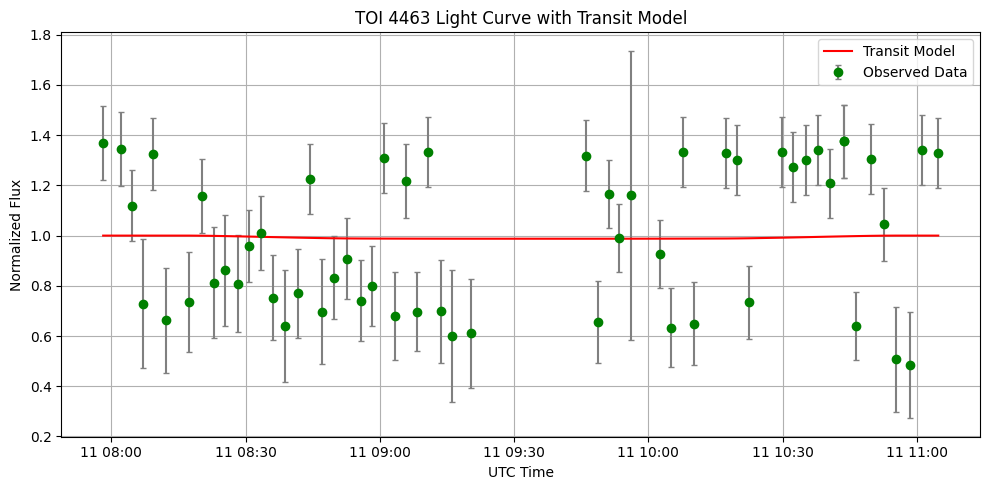

In [12]:
# Defining png for transit model curve
TOI4463_Model_filename="toi4463_model.png"

# Convert your observation times (astropy.Time) to JD float
times_jd = np.array([t.jd for t in times_sorted])  # times_sorted is your time list
fluxes = np.array(flux_sorted)
flux_errors = np.array(flux_err_sorted)

# === Set up the batman transit model using actual JD times ===
params = batman.TransitParams()
params.t0 = 2460806.90                 # Transit mid-point in JD
params.per = 6.54106                   # Period in days
params.rp = 0.1183 / 1.056             # Radius of planet over stellar radius
params.a = 15                          # Scaled semi-major axis (a/Rs)
params.inc = 87                        # Inclination in degrees
params.ecc = 0                         # Eccentricity
params.w = 90                          # Longitude of periastron
params.limb_dark = "quadratic"        # Limb darkening model
params.u = [0.1, 0.3]                  # Limb darkening coefficients

# Create model using JD times
m = batman.TransitModel(params, times_jd)
model_flux = m.light_curve(params)

# Converting JD to UTC for x-axis plotting.
times_utc = [Time(t, format='jd').to_datetime() for t in times_jd]

# Plotting the flux vs Time in UTC
plt.figure(figsize=(10, 5))
plt.errorbar(times_utc, fluxes, yerr=flux_errors, fmt='o', color='green', ecolor='gray', capsize=2, label='Observed Data')
plt.plot(times_utc, model_flux, 'r-', label='Transit Model')
plt.xlabel("UTC Time")
plt.ylabel("Normalized Flux")
plt.title("TOI 4463 Light Curve with Transit Model")
plt.grid(True)
plt.legend()
plt.savefig(TOI4463_Model_filename)
plt.tight_layout()
plt.show()